# &#x1F4D1; &nbsp;  Build  a  Digit Recognition Models

## Links
Multi-dimensional image processing https://docs.scipy.org/doc/scipy/reference/ndimage.html

Keras: Deep Learning library for Theano and TensorFlow https://keras.io/
 
Deep MNIST for Experts https://www.tensorflow.org/get_started/mnist/pros

Tensorflow Deep MNIST Advanced Tutorial http://docs.seldon.io/tensorflow-deep-mnist-example.html

Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras

http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

## Libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from time import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import matplotlib.cm as cm

%matplotlib inline

In [2]:
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


## Dataset

In [4]:
df_train = pd.read_csv("kaggle_train.csv")
df_test = pd.read_csv("kaggle_test.csv")

In [5]:
df_train.shape

(42000, 785)

In [18]:
df_train.ix[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18
15,0,0,0,0,0
16,0,0,0,0,0
17,0,0,0,0,0
18,0,0,0,0,0
19,0,0,0,0,0
20,0,0,0,0,0


In [7]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images = np.array(df_train[images])
train_images.shape

(42000, 784)

In [8]:
train_labels = df_train['label']
train_labels10 = np.array(ks.utils.to_categorical(train_labels, num_classes=10))
train_labels10.shape

(42000, 10)

In [9]:
test_images = np.array(df_test[images])
test_images.shape

(28000, 784)

In [10]:
test_images2 = test_images/255

In [11]:
train_images28 = np.array([np.reshape(x, (28, 28)) for x in train_images])
test_images28 = np.array([np.reshape(x, (28, 28)) for x in test_images])
train_images28n = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images28n = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_images28n, train_labels10, 
                                                    test_size=0.20, random_state=32)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33600, 28, 28, 1), (8400, 28, 28, 1), (33600, 10), (8400, 10))

In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_images/255, train_labels10, 
                                                        test_size=0.20, random_state=32)

In [15]:
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((33600, 784), (8400, 784), (33600, 10), (8400, 10))

In [16]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(train_images/255, train_labels, 
                                                        test_size=0.20, random_state=32)

In [20]:
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((33600, 784), (8400, 784), (33600,), (8400,))

## Examples

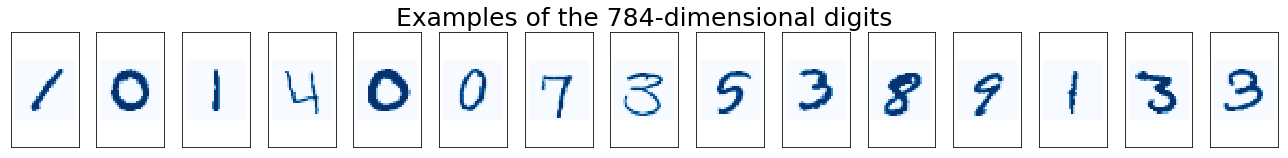

In [19]:
fig, ax = plt.subplots(figsize=(18, 2), nrows=1, ncols=15, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(15):
    image = train_images28[i]
    ax[i].imshow(image, cmap=plt.cm.Blues)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[7].set_title('Examples of the 784-dimensional digits', fontsize=25);

## Models

***Model #1. Convolutional Neural Network. Keras***

In [109]:
def cnn_mc_model():
    model_input = Input(shape=(28, 28, 1))
    x = BatchNormalization()(model_input)
    
    x = Conv2D(28, (5, 5), activation='relu', border_mode='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(56, (5, 5), activation='relu')(x)
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
#    x = Conv2D(112, (5, 5), activation='relu')(x)
#    x = Conv2D(112, (5, 5), activation='relu')(x)
#    x = MaxPooling2D(pool_size=(1, 1))(x)
#    x = Dropout(0.25)(x)
        
    x = Flatten()(x)
    
    x = Dense(224, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    y = Dense(10, activation='softmax')(x)
    
    model = Model(input=model_input, output=y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [110]:
cnn_mc_model = cnn_mc_model()

fit11 = cnn_mc_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                         epochs=20, batch_size=28, verbose=2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
89s - loss: 0.2441 - acc: 0.9224 - val_loss: 0.0554 - val_acc: 0.9829
Epoch 2/20
81s - loss: 0.0840 - acc: 0.9739 - val_loss: 0.0453 - val_acc: 0.9867
Epoch 3/20
80s - loss: 0.0656 - acc: 0.9804 - val_loss: 0.0330 - val_acc: 0.9896
Epoch 4/20
79s - loss: 0.0579 - acc: 0.9831 - val_loss: 0.0361 - val_acc: 0.9898
Epoch 5/20
80s - loss: 0.0504 - acc: 0.9846 - val_loss: 0.0334 - val_acc: 0.9900
Epoch 6/20
81s - loss: 0.0419 - acc: 0.9871 - val_loss: 0.0284 - val_acc: 0.9911
Epoch 7/20
79s - loss: 0.0400 - acc: 0.9877 - val_loss: 0.0341 - val_acc: 0.9913
Epoch 8/20
79s - loss: 0.0357 - acc: 0.9882 - val_loss: 0.0314 - val_acc: 0.9918
Epoch 9/20
79s - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0298 - val_acc: 0.9914
Epoch 10/20
79s - loss: 0.0286 - acc: 0.9912 - val_loss: 0.0269 - val_acc: 0.9933
Epoch 11/20
78s - loss: 0.0302 - acc: 0.9901 - val_loss: 0.0296 - val_acc: 0.9908
Epoch 12/20
78s - loss: 0.0269 - acc: 0.9911 - val_loss: 0

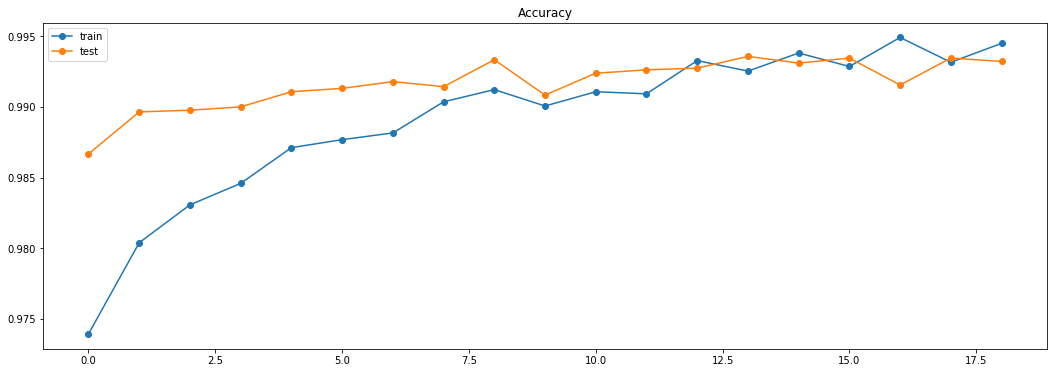

In [111]:
plt.figure(figsize=(18,6))
plt.plot(fit11.history['acc'][1:], '-o', label = 'train')
plt.plot(fit11.history['val_acc'][1:], '-o', label = 'test')
plt.legend()
plt.title('Accuracy');

In [112]:
cnn_scores = cnn_mc_model.evaluate(X_test, y_test, verbose=0)

print("CNN Scores: " , (cnn_scores))
print("CNN Error: %.2f%%" % (100 - cnn_scores[1]*100))
print(cnn_mc_model.summary())

CNN Scores:  [0.027909419039562115, 0.99321428571428572]
CNN Error: 0.68%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 28)        728       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 56)        39256     
_________________________________________________________________
ma

In [113]:
cnn_mc_model.save('kaggle_digits_cnn_mc_model_file4.h5')

***Model #2. Multi-layer Perceptron. Keras***

In [ ]:
def mlp_model():
    model_input = Input(shape=(784,))
    x = BatchNormalization()(model_input)   

    x = Dense(784, activation='relu')(x)    
    x = Dropout(0.5)(x)

    x = Dense(784, activation='relu')(x)
    x = Dropout(0.5)(x)

    y = Dense(10, activation='softmax')(x)
    
    model = Model(input=model_input, output=y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [127]:
def mlp_mc_model():
    model = Sequential()
    
    model.add(Dense(112, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    
    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [128]:
mlp_mc_model = mlp_mc_model()    

fit12 = mlp_mc_model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), 
                         epochs=20, batch_size=112, verbose=2);

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
7s - loss: 0.3591 - acc: 0.8930 - val_loss: 0.1559 - val_acc: 0.9527
Epoch 2/20
5s - loss: 0.1471 - acc: 0.9544 - val_loss: 0.1117 - val_acc: 0.9654
Epoch 3/20
5s - loss: 0.1055 - acc: 0.9672 - val_loss: 0.0987 - val_acc: 0.9702
Epoch 4/20
5s - loss: 0.0804 - acc: 0.9746 - val_loss: 0.0925 - val_acc: 0.9717
Epoch 5/20
5s - loss: 0.0651 - acc: 0.9796 - val_loss: 0.0887 - val_acc: 0.9730
Epoch 6/20
5s - loss: 0.0570 - acc: 0.9819 - val_loss: 0.0889 - val_acc: 0.9757
Epoch 7/20
6s - loss: 0.0471 - acc: 0.9838 - val_loss: 0.0875 - val_acc: 0.9749
Epoch 8/20
6s - loss: 0.0401 - acc: 0.9871 - val_loss: 0.0943 - val_acc: 0.9762
Epoch 9/20
6s - loss: 0.0375 - acc: 0.9869 - val_loss: 0.0995 - val_acc: 0.9738
Epoch 10/20
6s - loss: 0.0345 - acc: 0.9882 - val_loss: 0.0842 - val_acc: 0.9790
Epoch 11/20
5s - loss: 0.0323 - acc: 0.9886 - val_loss: 0.0867 - val_acc: 0.9780
Epoch 12/20
5s - loss: 0.0269 - acc: 0.9900 - val_loss: 0.0935 - val_

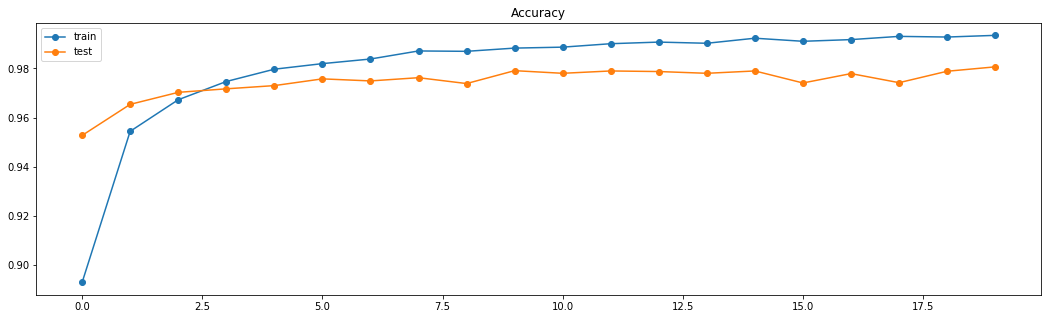

In [131]:
plt.figure(figsize=(18,5))
plt.plot(fit12.history['acc'], '-o', label = 'train')
plt.plot(fit12.history['val_acc'], '-o', label = 'test')
plt.legend()
plt.title('Accuracy');

In [132]:
mlp_scores = mlp_mc_model.evaluate(X_test2, y_test2)
print("\nMLP Scores: ", (mlp_scores))
print("MLP Error: %.2f%%" % (100 - mlp_scores[1] * 100))
print(mlp_mc_model.summary())

8400/8400 [==============================] - 0s     

MLP Scores:  [0.094420913739673512, 0.98059523809523808]
MLP E

In [133]:
mlp_mc_model.save('kaggle_digits_mlp_mc_model_file4.h5')

***Model #3. Recurrent Neural Network. Keras***

In [134]:
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(112, return_sequences=True, input_shape=(1,784)))
    
    model.add(LSTM(112, return_sequences=True)) 
    model.add(LSTM(112))  
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])    
    return model 

In [135]:
rnn_mc_model = rnn_mc_model()
fit13 = rnn_mc_model.fit(X_train2.reshape(X_train2.shape[0], 1, X_train2.shape[1]), y_train2, 
                         epochs=20, batch_size=112, verbose=2,
                         validation_data=(X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1]), y_test2))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
43s - loss: 0.3472 - acc: 0.8954 - val_loss: 0.1560 - val_acc: 0.9519
Epoch 2/20
38s - loss: 0.1211 - acc: 0.9626 - val_loss: 0.1119 - val_acc: 0.9646
Epoch 3/20
39s - loss: 0.0755 - acc: 0.9759 - val_loss: 0.0936 - val_acc: 0.9726
Epoch 4/20
38s - loss: 0.0514 - acc: 0.9833 - val_loss: 0.0883 - val_acc: 0.9740
Epoch 5/20
36s - loss: 0.0383 - acc: 0.9880 - val_loss: 0.0827 - val_acc: 0.9769
Epoch 6/20
41s - loss: 0.0278 - acc: 0.9914 - val_loss: 0.1154 - val_acc: 0.9667
Epoch 7/20
38s - loss: 0.0245 - acc: 0.9923 - val_loss: 0.0978 - val_acc: 0.9760
Epoch 8/20
37s - loss: 0.0201 - acc: 0.9938 - val_loss: 0.0902 - val_acc: 0.9782
Epoch 9/20
41s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.1021 - val_acc: 0.9730
Epoch 10/20
40s - loss: 0.0159 - acc: 0.9947 - val_loss: 0.0960 - val_acc: 0.9764
Epoch 11/20
41s - loss: 0.0119 - acc: 0.9960 - val_loss: 0.0981 - val_acc: 0.9774
Epoch 12/20
43s - loss: 0.0157 - acc: 0.9948 - val_loss: 0

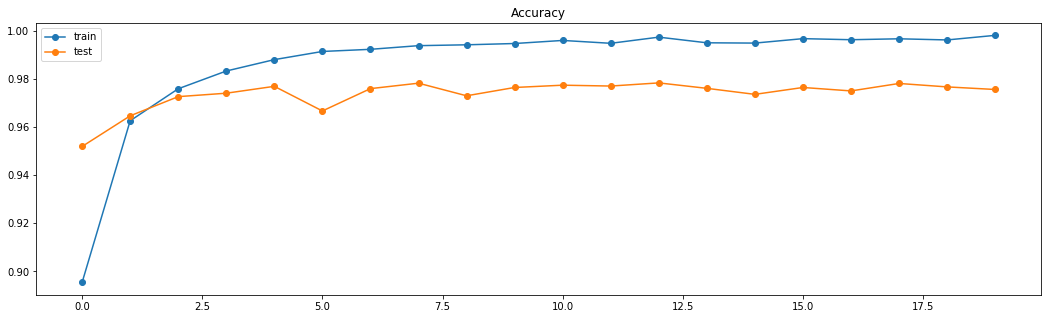

In [136]:
plt.figure(figsize=(18,5))
plt.plot(fit13.history['acc'], '-o', label = 'train')
plt.plot(fit13.history['val_acc'], '-o', label = 'test')
plt.legend()
plt.title('Accuracy');

In [137]:
rnn_scores = rnn_mc_model.evaluate(X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1]), y_test2)
print("\nRNN Scores: ", (rnn_scores))
print("RNN Error: %.2f%%" % (100 - rnn_scores[1] * 100))
print(rnn_mc_model.summary())

8384/8400 [============================>.] - ETA: 0s

In [41]:
rnn_mc_model.save('kaggle_digits_rnn_mc_model_file4.h5')

***Model #4. MLPClassifier. Scikit-learn***

In [138]:
clf1 = MLPClassifier(hidden_layer_sizes=(784,), max_iter=16, alpha=1e-4,
                     solver='adam', verbose=1, tol=1e-5, random_state=1,
                     learning_rate_init=7e-4, batch_size=56)
clf1.fit(X_train3, y_train3);

Iteration 1, loss = 0.29003719
Iteration 2, loss = 0.12064723
Iteration 3, loss = 0.07739500
Iteration 4, loss = 0.05337941
Iteration 5, loss = 0.03750909
Iteration 6, loss = 0.02639754
Iteration 7, loss = 0.02017390
Iteration 8, loss = 0.01646501
Iteration 9, loss = 0.01398885
Iteration 10, loss = 0.01095037
Iteration 11, loss = 0.00864257
Iteration 12, loss = 0.00980719
Iteration 13, loss = 0.01235807
Iteration 14, loss = 0.00654673
Iteration 15, loss = 0.00706290
Iteration 16, loss = 0.00487617


In [139]:
print("MNIST. MLPClassifier. Train score: %f" % (clf1.score(X_train3, y_train3)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf1.score(X_test3, y_test3)*100),'%')

MNIST. MLPClassifier. Train score: 99.964286 %
MNIST. MLPClassifier. Test score: 97.916667 %


In [140]:
clf2 = MLPClassifier(hidden_layer_sizes=(784,), max_iter=16, alpha=1e-4,
                     solver='adam', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=112)
clf2.fit(X_train3, y_train3);

Iteration 1, loss = 0.33882588
Iteration 2, loss = 0.14660743
Iteration 3, loss = 0.09803284
Iteration 4, loss = 0.06931923
Iteration 5, loss = 0.05183953
Iteration 6, loss = 0.03845125
Iteration 7, loss = 0.02994105
Iteration 8, loss = 0.02101424
Iteration 9, loss = 0.01690380
Iteration 10, loss = 0.01221100
Iteration 11, loss = 0.00952089
Iteration 12, loss = 0.00848824
Iteration 13, loss = 0.00627094
Iteration 14, loss = 0.00422556
Iteration 15, loss = 0.00338273
Iteration 16, loss = 0.00290945


In [141]:
print("MNIST. MLPClassifier #2. Train score: %f" % (clf2.score(X_train3, y_train3)*100),'%')
print("MNIST. MLPClassifier #2. Test score: %f" % (clf2.score(X_test3, y_test3)*100),'%')

MNIST. MLPClassifier #2. Train score: 100.000000 %
MNIST. MLPClassifier #2. Test score: 98.023810 %


## Predictions

In [142]:
predict_labels1 = cnn_mc_model.predict(test_images28n)
predict_labels1 = predict_labels1.argmax(axis=-1)
predict_labels1[:100]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 8, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [143]:
predict_labels2 = mlp_mc_model.predict_classes(test_images2)
predict_labels2[:100]

27776/28000 [============================>.] - ETA: 0s  

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 5, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 8, 9, 2, 3, 5, 7, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [144]:
predict_labels3 = rnn_mc_model.predict_classes(test_images2.reshape(test_images2.shape[0], 1, test_images2.shape[1]))
predict_labels3[:100]

28000/28000 [==============================] - 13s      

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 5, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 5, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [145]:
predict_labels4 = clf2.predict(test_images2)

In [146]:
submission1 = pd.DataFrame({"ImageId": range(1, len(predict_labels1)+1), "Label": predict_labels1})
print(submission1[0:20])

submission1.to_csv('kaggle_digits_cnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [147]:
submission2 = pd.DataFrame({"ImageId": range(1, len(predict_labels2)+1), "Label": predict_labels2})
print(submission2[:20])

submission2.to_csv('kaggle_digits_mlp_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      5
16       17      3
17       18      1
18       19      9
19       20      0


In [148]:
submission3 = pd.DataFrame({"ImageId": range(1, len(predict_labels3)+1), "Label": predict_labels3})
print(submission3[0:20])

submission3.to_csv('kaggle_digits_rnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      5
16       17      3
17       18      1
18       19      9
19       20      0


In [149]:
submission4 = pd.DataFrame({"ImageId": range(1, len(predict_labels3)+1), "Label": predict_labels4})
print(submission4[0:20])

submission4.to_csv('kaggle_digits_mlpc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [150]:
real_data = np.array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3,
                      5, 7, 4, 0, 4, 3, 3, 1, 9, 0,
                      9, 1, 1, 5, 7, 4, 2, 7, 4, 7,
                      7, 5, 4, 2, 6, 2, 5, 5, 1, 6,
                      7, 7, 4, 9, 8, 7, 8, 2, 6, 7,
                      6, 8, 8, 3, 8, 2, 1, 2, 2, 0,
                      4, 1, 7, 0, 0, 0, 1, 9, 0, 1,
                      6, 5, 8, 8, 2, 8, 9, 9, 2, 3,
                      5, 4, 1, 0, 9, 2, 4, 3, 6, 7,
                      2, 0, 6, 6, 1, 4, 3, 9, 7, 4,
                      0, 9, 2, 0, 7, 3, 0, 5, 0, 8,
                      0, 0, 4, 7, 1, 7, 1, 1, 3, 3,
                      3, 7, 2, 8, 6, 3, 8, 7, 7, 4,
                      3, 5, 4, 0, 0, 0, 3, 1, 3, 6,
                      4, 3, 4, 5, 5, 8, 7, 4, 2, 8,
                      4, 3, 5, 6, 5, 3, 7, 5, 7, 8,
                      3, 0, 4, 5, 1, 3, 7, 6, 3, 0,
                      2, 7, 8, 6, 1, 3, 7, 4, 1, 2,
                      4, 8, 5, 2, 4, 9, 2, 1, 6, 0,
                      6, 1, 4, 9, 6, 0, 9, 7, 6, 9])

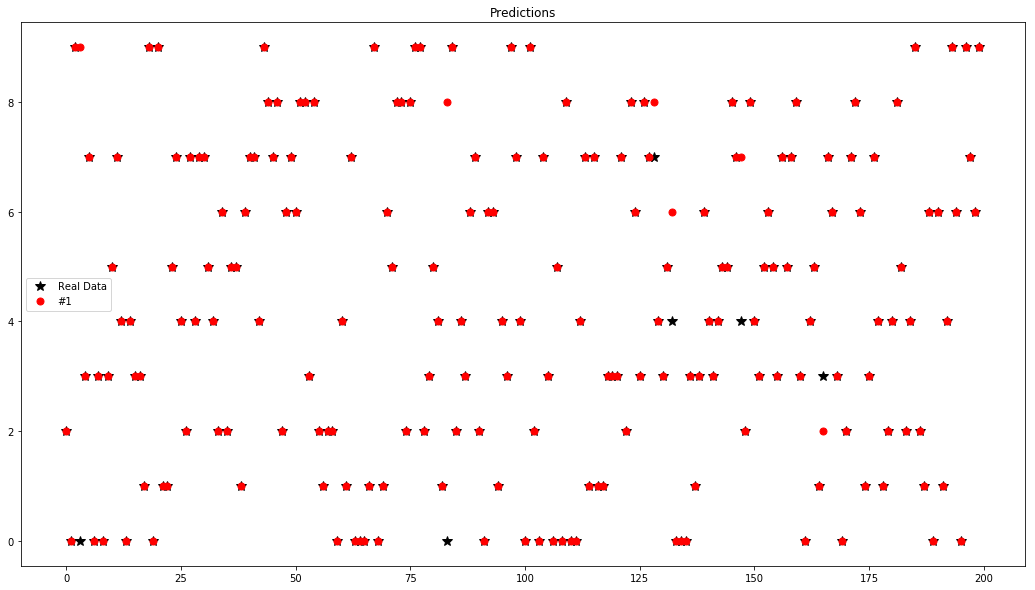

In [151]:
plt.figure(figsize = (18, 10))

plt.plot(real_data[0:200], '*', c='black', ms=10, label='Real Data')

plt.plot(submission1['Label'][0:200], 'o', c='red', ms=7, label='#1')
# plt.plot(submission2['Label'][0:200], 'v', c='red', ms=7, label='#2')
# plt.plot(submission3['Label'][0:200], 's', c='red', ms=7, label='#3')
# plt.plot(submission4['Label'][0:200], 'p', c='red', ms=7, label='#4')

plt.legend(loc=6)
plt.title("Predictions");

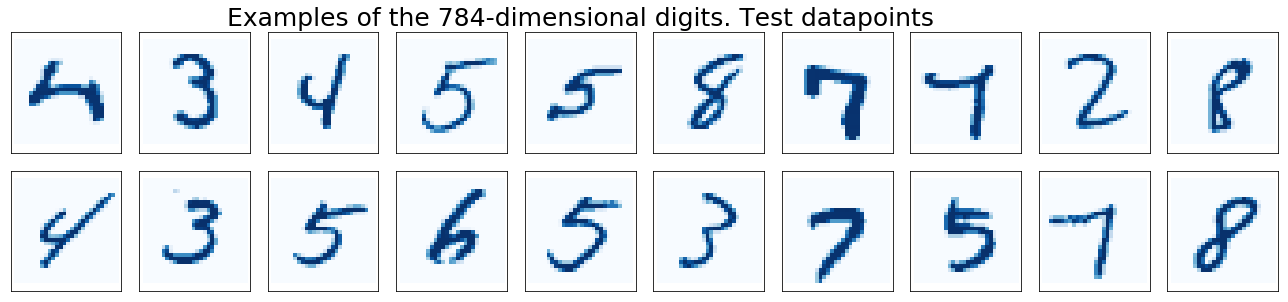

In [152]:
fig, ax = plt.subplots(figsize=(18, 4), nrows=2, ncols=10, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(20):
    image = test_images28[140:160][i]
    ax[i].imshow(image, cmap=plt.cm.Blues)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[4].set_title('Examples of the 784-dimensional digits. Test datapoints', fontsize=25);